In [1]:
import os
import re
from typing import List

import click
import dnnlib
import numpy as np
import PIL.Image as Image
import torch

import legacy

In [2]:
network_pkl = "../model/network-snapshot-000080.pkl"

In [3]:
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

In [4]:
with dnnlib.util.open_url(network_pkl) as f:
    pkl_file = legacy.load_network_pkl(f)

In [5]:
pkl_file.keys()

dict_keys(['training_set_kwargs', 'G', 'D', 'G_ema', 'augment_pipe'])

In [6]:
pkl_file['G']

Generator(
  (synthesis): SynthesisNetwork(
    (b4): SynthesisBlock(
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b8): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b16): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b32): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConn

In [10]:
pkl_file['D']

Discriminator(
  (b1024): DiscriminatorBlock(
    (fromrgb): Conv2dLayer()
    (conv0): Conv2dLayer()
    (conv1): Conv2dLayer()
    (skip): Conv2dLayer()
  )
  (b512): DiscriminatorBlock(
    (conv0): Conv2dLayer()
    (conv1): Conv2dLayer()
    (skip): Conv2dLayer()
  )
  (b256): DiscriminatorBlock(
    (conv0): Conv2dLayer()
    (conv1): Conv2dLayer()
    (skip): Conv2dLayer()
  )
  (b128): DiscriminatorBlock(
    (conv0): Conv2dLayer()
    (conv1): Conv2dLayer()
    (skip): Conv2dLayer()
  )
  (b64): DiscriminatorBlock(
    (conv0): Conv2dLayer()
    (conv1): Conv2dLayer()
    (skip): Conv2dLayer()
  )
  (b32): DiscriminatorBlock(
    (conv0): Conv2dLayer()
    (conv1): Conv2dLayer()
    (skip): Conv2dLayer()
  )
  (b16): DiscriminatorBlock(
    (conv0): Conv2dLayer()
    (conv1): Conv2dLayer()
    (skip): Conv2dLayer()
  )
  (b8): DiscriminatorBlock(
    (conv0): Conv2dLayer()
    (conv1): Conv2dLayer()
    (skip): Conv2dLayer()
  )
  (b4): DiscriminatorEpilogue(
    (mbstd): Mini

In [12]:
pkl_file['G_ema']

Generator(
  (synthesis): SynthesisNetwork(
    (b4): SynthesisBlock(
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b8): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b16): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b32): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConn

In [7]:
# row_seeds = [1,100121212, 82]
# col_seeds = [2,55,34]
row_seeds = [1239491]
col_seeds = [49494949]
truncation_psi = 1
noise_mode = 'const'
col_styles = [0,1,2,3,4,5]

In [8]:
all_seeds = list(set(row_seeds + col_seeds))
all_z = np.stack([np.random.RandomState(seed).randn(G.z_dim) for seed in all_seeds])
all_w = G.mapping(torch.from_numpy(all_z).to(device), None)
w_avg = G.mapping.w_avg
all_w = w_avg + (all_w - w_avg) * truncation_psi
w_dict = {seed: w for seed, w in zip(all_seeds, list(all_w))}

Setting up PyTorch plugin "bias_act_plugin"... 

C:\Users\User\anaconda3\envs\tes_proj\lib\site-packages\torch\utils\cpp_extension.py:305: UserWarning: Error checking compiler version for cl: 'utf-8' codec can't decode byte 0xc3 in position 20: invalid continuation byte
  warnings.warn(f'Error checking compiler version for {compiler}: {error}')


Done.


In [9]:
all_z.shape

(2, 512)

In [10]:
all_w.shape

torch.Size([2, 14, 512])

In [11]:
w_dict.keys()

dict_keys([1239491, 49494949])

In [12]:
w_dict

{1239491: tensor([[ 2.3683,  1.9539,  1.8136,  ...,  1.2966,  1.1710, -0.0139],
         [ 2.3683,  1.9539,  1.8136,  ...,  1.2966,  1.1710, -0.0139],
         [ 2.3683,  1.9539,  1.8136,  ...,  1.2966,  1.1710, -0.0139],
         ...,
         [ 2.3683,  1.9539,  1.8136,  ...,  1.2966,  1.1710, -0.0139],
         [ 2.3683,  1.9539,  1.8136,  ...,  1.2966,  1.1710, -0.0139],
         [ 2.3683,  1.9539,  1.8136,  ...,  1.2966,  1.1710, -0.0139]],
        device='cuda:0'),
 49494949: tensor([[ 0.2396, -0.2691,  0.6523,  ...,  0.1307, -0.1860, -0.0718],
         [ 0.2396, -0.2691,  0.6523,  ...,  0.1307, -0.1860, -0.0718],
         [ 0.2396, -0.2691,  0.6523,  ...,  0.1307, -0.1860, -0.0718],
         ...,
         [ 0.2396, -0.2691,  0.6523,  ...,  0.1307, -0.1860, -0.0718],
         [ 0.2396, -0.2691,  0.6523,  ...,  0.1307, -0.1860, -0.0718],
         [ 0.2396, -0.2691,  0.6523,  ...,  0.1307, -0.1860, -0.0718]],
        device='cuda:0')}

In [13]:
for t in w_dict[1239491] :
    for i in range(50):
        t[i] = 0.9999
    for j in range(50,100) :
        t[j] = 0.2312
    for f in range(100,400) :
        t[f] = 0.4322

In [14]:
w_dict

{1239491: tensor([[ 0.9999,  0.9999,  0.9999,  ...,  1.2966,  1.1710, -0.0139],
         [ 0.9999,  0.9999,  0.9999,  ...,  1.2966,  1.1710, -0.0139],
         [ 0.9999,  0.9999,  0.9999,  ...,  1.2966,  1.1710, -0.0139],
         ...,
         [ 0.9999,  0.9999,  0.9999,  ...,  1.2966,  1.1710, -0.0139],
         [ 0.9999,  0.9999,  0.9999,  ...,  1.2966,  1.1710, -0.0139],
         [ 0.9999,  0.9999,  0.9999,  ...,  1.2966,  1.1710, -0.0139]],
        device='cuda:0'),
 49494949: tensor([[ 0.2396, -0.2691,  0.6523,  ...,  0.1307, -0.1860, -0.0718],
         [ 0.2396, -0.2691,  0.6523,  ...,  0.1307, -0.1860, -0.0718],
         [ 0.2396, -0.2691,  0.6523,  ...,  0.1307, -0.1860, -0.0718],
         ...,
         [ 0.2396, -0.2691,  0.6523,  ...,  0.1307, -0.1860, -0.0718],
         [ 0.2396, -0.2691,  0.6523,  ...,  0.1307, -0.1860, -0.0718],
         [ 0.2396, -0.2691,  0.6523,  ...,  0.1307, -0.1860, -0.0718]],
        device='cuda:0')}

In [15]:
all_images = G.synthesis(all_w, noise_mode=noise_mode)
all_images = (all_images.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu().numpy()
image_dict = {(seed, seed): image for seed, image in zip(all_seeds, list(all_images))}

Setting up PyTorch plugin "upfirdn2d_plugin"... 

C:\Users\User\anaconda3\envs\tes_proj\lib\site-packages\torch\utils\cpp_extension.py:305: UserWarning: Error checking compiler version for cl: 'utf-8' codec can't decode byte 0xc3 in position 20: invalid continuation byte
  warnings.warn(f'Error checking compiler version for {compiler}: {error}')


Done.


In [16]:
image_dict

{(1239491,
  1239491): array([[[232, 231, 238],
         [241, 240, 246],
         [245, 245, 249],
         ...,
         [247, 246, 250],
         [243, 243, 248],
         [233, 231, 238]],
 
        [[245, 244, 250],
         [246, 245, 251],
         [248, 247, 252],
         ...,
         [247, 246, 251],
         [247, 247, 251],
         [246, 244, 250]],
 
        [[249, 248, 253],
         [247, 246, 251],
         [248, 247, 251],
         ...,
         [247, 245, 250],
         [245, 244, 248],
         [246, 245, 250]],
 
        ...,
 
        [[236, 235, 241],
         [236, 236, 242],
         [236, 235, 242],
         ...,
         [242, 240, 246],
         [241, 240, 246],
         [238, 237, 243]],
 
        [[230, 228, 237],
         [238, 237, 244],
         [238, 237, 244],
         ...,
         [243, 241, 248],
         [242, 241, 248],
         [235, 233, 240]],
 
        [[216, 215, 221],
         [234, 233, 239],
         [236, 235, 241],
         ...,
      

In [17]:
all_images.shape

(2, 256, 256, 3)

In [18]:
all_images[0].shape

(256, 256, 3)

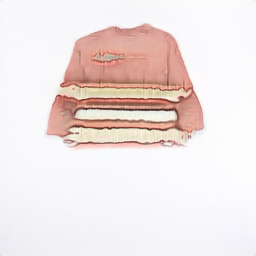

In [20]:
Image.fromarray(np.uint8(all_images[1]))

In [174]:
print('Generating style-mixed images...')
for row_seed in row_seeds:
    for col_seed in col_seeds:
        w = w_dict[row_seed].clone()
        w[col_styles] = w_dict[col_seed][col_styles]
        image = G.synthesis(w[np.newaxis], noise_mode=noise_mode)
        image = (image.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        image_dict[(row_seed, col_seed)] = image[0].cpu().numpy() #추가한거네.

Generating style-mixed images...


In [175]:
image = G.synthesis(w[np.newaxis], noise_mode=noise_mode)
image

tensor([[[[-0.4222, -0.5963, -0.6596,  ..., -0.7657, -0.7366, -0.5853],
          [-0.6400, -0.7216, -0.7316,  ..., -0.7929, -0.7780, -0.6907],
          [-0.6886, -0.7657, -0.7332,  ..., -0.7897, -0.7886, -0.6984],
          ...,
          [-0.5365, -0.5337, -0.5178,  ..., -0.6890, -0.6789, -0.6587],
          [-0.4594, -0.5370, -0.5506,  ..., -0.7138, -0.6764, -0.5882],
          [-0.3259, -0.5190, -0.5394,  ..., -0.6828, -0.5728, -0.4394]],

         [[-0.4853, -0.6458, -0.7128,  ..., -0.8204, -0.8049, -0.6667],
          [-0.6847, -0.7497, -0.7696,  ..., -0.8232, -0.8265, -0.7706],
          [-0.7389, -0.8061, -0.7830,  ..., -0.8223, -0.8285, -0.7658],
          ...,
          [-0.6810, -0.6825, -0.6800,  ..., -0.7757, -0.7701, -0.7807],
          [-0.5942, -0.6678, -0.6910,  ..., -0.7981, -0.7686, -0.7098],
          [-0.4534, -0.6361, -0.6676,  ..., -0.7724, -0.6719, -0.5603]],

         [[-0.5161, -0.6654, -0.7306,  ..., -0.8335, -0.8440, -0.7287],
          [-0.6912, -0.7610, -

In [176]:
image_dict

{(1239491,
  1239491): array([[[74, 66, 62],
         [52, 45, 42],
         [44, 37, 34],
         ...,
         [32, 24, 22],
         [36, 26, 21],
         [54, 43, 35]],
 
        [[47, 41, 40],
         [36, 32, 30],
         [35, 29, 27],
         ...,
         [29, 24, 21],
         [31, 24, 19],
         [42, 31, 24]],
 
        [[41, 34, 33],
         [31, 25, 22],
         [35, 28, 24],
         ...,
         [30, 24, 21],
         [30, 23, 19],
         [41, 32, 26]],
 
        ...,
 
        [[36, 27, 22],
         [34, 27, 21],
         [33, 27, 21],
         ...,
         [45, 31, 22],
         [46, 31, 22],
         [48, 30, 20]],
 
        [[45, 36, 28],
         [37, 30, 24],
         [31, 24, 19],
         ...,
         [42, 29, 19],
         [47, 32, 22],
         [57, 39, 28]],
 
        [[62, 52, 42],
         [37, 30, 23],
         [32, 25, 19],
         ...,
         [47, 33, 24],
         [59, 44, 34],
         [74, 57, 46]]], dtype=uint8),
 (49494949,
  494949

In [107]:
w[col_styles].shape

torch.Size([6, 512])

In [116]:
w = w_dict[row_seed].clone()
w.shape

torch.Size([18, 512])

In [118]:
w[col_styles] = w_dict[col_seed][col_styles]
print(w.shape)
print(w[col_styles].shape) # 앞을 교체 하는거네

torch.Size([18, 512])
torch.Size([6, 512])


In [119]:
w

tensor([[-0.1137, -0.2684,  0.4410,  ..., -0.0823, -0.1669, -0.2211],
        [-0.1137, -0.2684,  0.4410,  ..., -0.0823, -0.1669, -0.2211],
        [-0.1137, -0.2684,  0.4410,  ..., -0.0823, -0.1669, -0.2211],
        ...,
        [ 0.8510, -0.1993,  0.2701,  ...,  0.8389, -0.1872, -0.0100],
        [ 0.8510, -0.1993,  0.2701,  ...,  0.8389, -0.1872, -0.0100],
        [ 0.8510, -0.1993,  0.2701,  ...,  0.8389, -0.1872, -0.0100]],
       device='cuda:0')

In [121]:
w[np.newaxis].shape

torch.Size([1, 18, 512])

In [95]:
image_dict.keys()

dict_keys([(1239491, 1239491), (49494949, 49494949), (1239491, 49494949)])

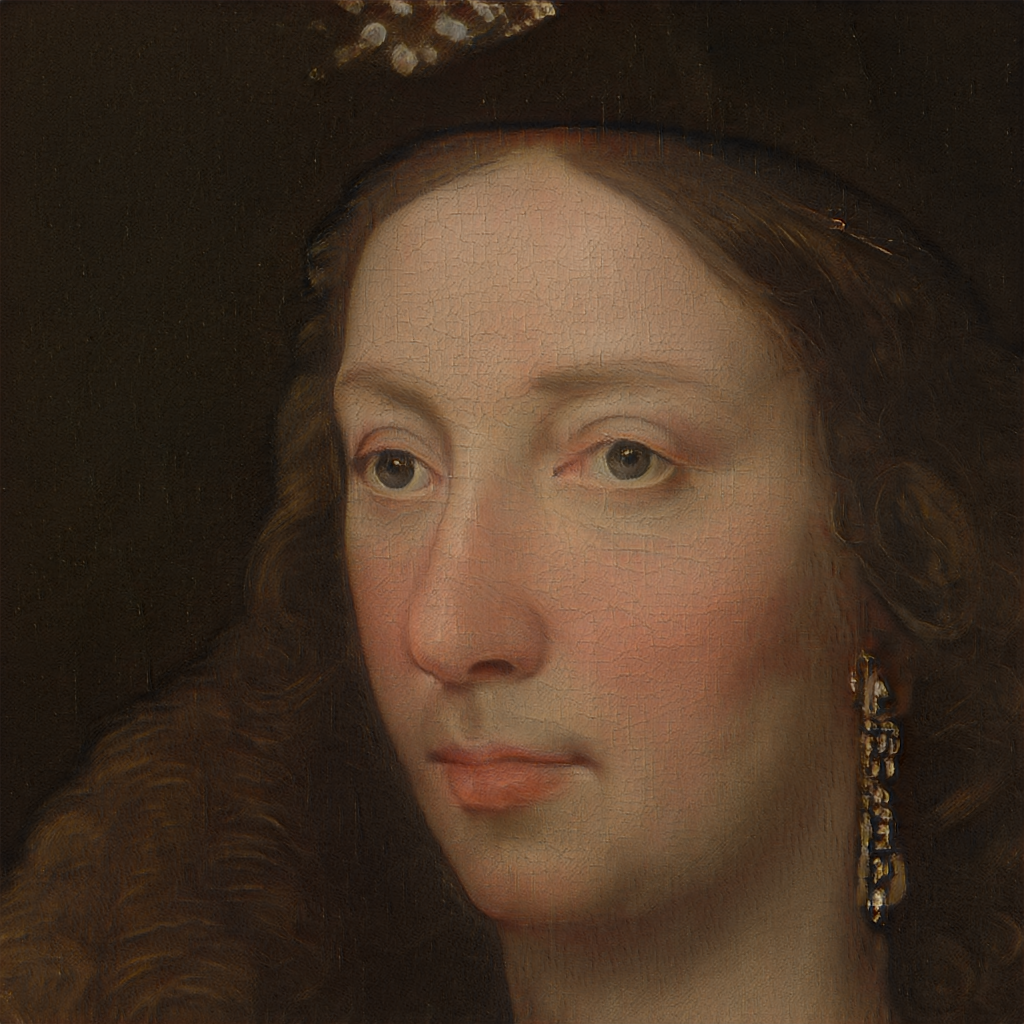

In [177]:
img = image_dict[ (1239491, 49494949)]
Image.fromarray(np.uint8(img))